In [1]:
from concurrent.futures import ProcessPoolExecutor, as_completed
from igraph import Graph
from scipy.stats import spearmanr
from statsmodels.sandbox.stats.multicomp import multipletests
import numpy as np
import random
from tqdm import tqdm
import logging
from scipy.linalg import eigh

# Set up logging
logging.basicConfig(level=logging.INFO)

# Function to calculate the Laplacian spectrum
def laplacian_spectrum(graph):
    laplacian = graph.laplacian(normalized=True)
    #eigenvalues = np.linalg.eigvalsh(laplacian)
    eigenvalues = np.sort(eigh(laplacian, eigvals_only=True))
    return eigenvalues

# Function to randomize a graph while preserving degree distribution
def randomize_graph(graph):
    # Implement your preferred graph randomization method here
    randomized_graph = graph.copy()
    randomized_graph.rewire(n=graph.ecount() * 10)  # 10 rewires per edge, on average
    return randomized_graph

# Function to calculate the Spearman correlation
def calculate_correlation(original_spectrum, randomized_spectrum):
    correlation, p_value = spearmanr(original_spectrum, randomized_spectrum)
    return correlation, p_value

# Function to calculate the correlation for a single randomized graph
def single_randomized_correlation(original_graph, original_spectrum):
    randomized_graph = randomize_graph(original_graph)
    randomized_spectrum = laplacian_spectrum(randomized_graph)
    return calculate_correlation(original_spectrum, randomized_spectrum)

# Main function to calculate correlations for multiple randomized graphs
def multiple_randomized_correlations(original_graph, num_randomizations):
    logging.info("Calculating original spectrum...")
    original_spectrum = laplacian_spectrum(original_graph)

    with ProcessPoolExecutor() as executor:
        logging.info("Submitting jobs for randomizations...")
        future_results = [executor.submit(single_randomized_correlation, original_graph, original_spectrum)
                          for _ in range(num_randomizations)]

        correlations = []
        p_values = []

        # Create a progress bar
        progress_bar = tqdm(total=num_randomizations, desc="Processing randomizations", position=0)

        for future in as_completed(future_results):
            correlation, p_value = future.result()
            correlations.append(correlation)
            p_values.append(p_value)

            # Update the progress bar
            progress_bar.update(1)

            logging.info(f"Finished processing randomization {len(correlations)} of {num_randomizations}")

        # Ensure the progress bar is complete
        progress_bar.close()

    logging.info("Finished all randomizations.")
    return correlations, p_values

# Function to perform Bonferroni correction
def bonferroni_correction(p_values):
    corrected_p_values = multipletests(p_values, method='bonferroni')[1]
    return corrected_p_values


In [35]:
original_spectrum = laplacian_spectrum(original_graph)
curr_corr = single_randomized_correlation(original_graph, original_spectrum)

In [37]:
curr_corr

(1.0, 0.0)

In [36]:
correlation, p_value = curr_corr[0], curr_corr[1]
print(correlation, p_value)

1.0 0.0


In [2]:
from scipy import sparse

In [3]:
# Create the original graph
slice10_path = '/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/data/ca1_ca3_to_slice10_synaptome.npz'
slice10 = sparse.load_npz(slice10_path)
slice10_internal = slice10[:slice10.shape[1],:]
del slice10
original_graph = Graph.Adjacency(slice10_internal.A)


In [22]:
original_graph.density()

0.09652777450468218

In [24]:
original_graph['name'] = 'slice10'

In [28]:
from bluepy import Circuit
circuitconfig_path = '/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/CircuitConfig'
c = Circuit(circuitconfig_path)

['SLM_PPA', 'SLM_PPA', 'SLM_PPA', 'SLM_PPA', 'SLM_PPA', ..., 'SO_BP', 'SO_BP', 'SO_BP', 'SO_BP', 'SO_BP']
Length: 12615
Categories (12, object): ['SLM_PPA', 'SO_BP', 'SO_BS', 'SO_OLM', ..., 'SP_Ivy', 'SP_PC', 'SP_PVBC', 'SR_SCA']

In [32]:
original_graph.vs['mtype'] = c.cells.get('slice10').mtype.values
original_graph.vs['etype'] = c.cells.get('slice10').etype.values
original_graph.vs['layer'] = c.cells.get('slice10').layer.values

In [34]:
original_graph

In [4]:
# Calculate correlations for multiple randomized graphs
correlations, p_values = multiple_randomized_correlations(original_graph, num_randomizations=5)

INFO:root:Calculating original spectrum...
INFO:root:Submitting jobs for randomizations...
Processing randomizations: 100%|██████████| 5/5 [14:13<00:00, 170.71s/it]
INFO:root:Finished all randomizations.


In [11]:
original_graph

In [5]:

# Perform Bonferroni correction
corrected_p_values = bonferroni_correction(p_values)

In [10]:
p_values

[0.0, 0.0, 0.0, 0.0, 0.0]

In [7]:
import matplotlib.pyplot as plt

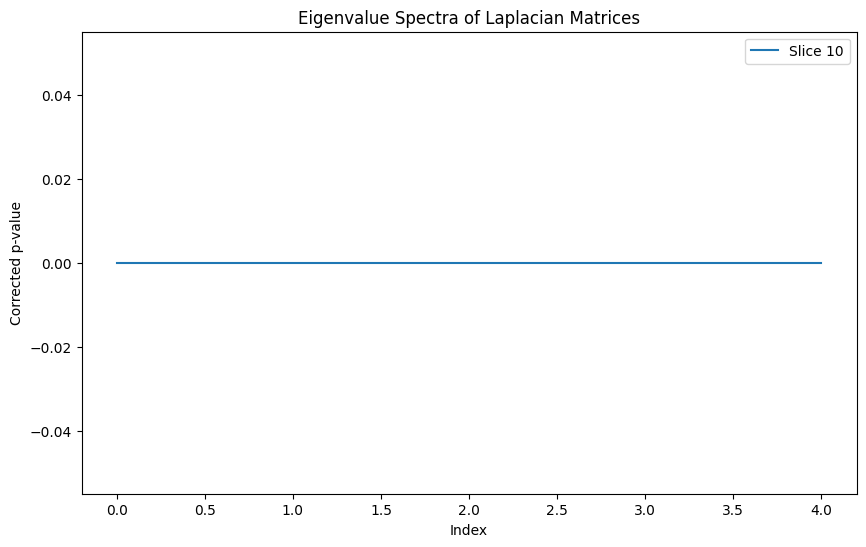

In [8]:
# plot eigenvalue spectra
plt.figure(figsize=(10, 6))
plt.plot(corrected_p_values, label='Slice 10')
plt.xlabel('Index')
plt.ylabel('Corrected p-value')
plt.legend()
plt.title('Eigenvalue Spectra of Laplacian Matrices')
plt.show()